In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../')

import read_trace
import cuda_timeline
from avgblkmodel import *
import cke
from df_util import *
#from model_cke import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [271]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

# 2 stream info

In [272]:
# 10M for mem_mem : where the h2d between streams are overlapped
trace_file = 'trace_10M_s1.csv'
trace_file_2cke = 'trace_h2d_h2d_ovlp.csv'

df_trace = read_trace.trace2dataframe(trace_file) # read the trace to the dataframe
df_trace_2cke = read_trace.trace2dataframe(trace_file_2cke)

In [273]:
#df_trace

In [274]:
#cuda_timeline.plot_trace(df_trace)

In [275]:
#df_trace_2cke

In [276]:
#cuda_timeline.plot_trace(df_trace_2cke)

# 1cke - read trace and reset the timeline

In [277]:
df_single_stream = read_trace.get_timing(df_trace)

In [278]:
df_single_stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,610.840271,617.277086,38146.973,6.436815
1,0.0,h2d,617.278302,623.708301,38146.973,6.429999
2,0.0,kern,623.719789,624.996407,0.000,1.276618
3,0.0,d2h,625.003191,631.272837,38146.973,6.269646


In [279]:
df_s1 = read_trace.reset_starting(df_single_stream)

In [280]:
#df_s1

### 2cke case

In [281]:
df_2stream = read_trace.get_timing(df_trace_2cke)

In [282]:
df_2stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,665.032627,675.815726,38146.973,10.783099
1,0.0,h2d,675.816942,688.730069,38146.973,12.913127
2,0.0,kern,688.741397,690.119293,0.000,1.377896
3,0.0,d2h,690.126461,700.784951,38146.973,10.658490
4,1.0,h2d,668.190628,681.089483,38146.973,12.898855
5,1.0,h2d,681.090667,691.303811,38146.973,10.213144
6,1.0,kern,691.316867,692.682987,0.000,1.366120
7,1.0,d2h,693.294222,702.817090,38146.973,9.522868


In [283]:
tot_runtime = read_trace.getTotalRuntime(df_2stream)
print tot_runtime

37.784463


# 2 cke

In [284]:
stream_num = 2

# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

In [285]:
#df_cke_list[0]

In [286]:
#df_cke_list[1]

### sort

In [287]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [288]:
#df_all_api

In [289]:
#df_all_api.loc[df_all_api.stream_id == 0]

In [290]:
# print df_all_api.iloc[0]
# print df_all_api.iloc[1]

In [291]:
#df_all_api

In [292]:
# pick the 1st sleep call and wake up
r1 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r1)

# pick another in the sleep mode, if it is from the same stream, there is non ovlp
r2 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r2)
#print('r2 {}'.format(r2))

# check concurrency
conc = cke.check_cc(df_all_api, r1, r2)

# concurrency
if conc == True:
    df_all_api = cke.update_before_conc(df_all_api, r1, r2)
    # set r2 to wake
    df_all_api = SetWake(df_all_api, r2)
    # current concurrency
    cc = 2.0
    # predict with concurrency for rows 0 and 1
    df_all_api = cke.Predict_end(df_all_api, [r1, r2], ways = cc)
    # get the time range from wake api, to check the next concurrent api
    rangeT = cke.Get_next_range(df_all_api)
    #print rangeT
    
    extra_conc = cke.check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
    
    if extra_conc == 0: # update timing using the pred_end
        df_all_api = cke.Update_with_pred_end(df_all_api, rangeT, ways = cc)
        # check if any api is done, and update the timing for the other apis in that stream
        df_all_api = cke.UpdateStreamTime(df_all_api)

In [293]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,9.715199,h2d,38146.973,0.0,done,5926.373991,38146.97300,0.00000,9.715199,0.0,9.715199
4,3.158431,9.595246,h2d,38146.973,1.0,wake,5926.373991,19428.92967,18718.04333,9.715199,0.0,0.000000
1,9.716415,16.146414,h2d,38146.973,0.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.000000
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.000000
2,16.157902,17.434520,kern,0.000,0.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.000000
3,17.441304,23.710950,d2h,38146.973,0.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.000000
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.000000
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.000000


In [294]:
## select the next api/call to wake it up

# pick another in the sleep mode, if it is from the same stream, there is non ovlp
r3 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r3)
#print r3

# the current_pos is ahead of coming call start: move to the next start
df_all_api = cke.StartNext(df_all_api, [r2, r3])

# check the concurrency, and predict accordingly
# check concurrency
df_all_api = cke.Predict_checkCC(df_all_api, r2, r3)

# get the time range from wake api, to check the next concurrent api
rangeT = cke.Get_next_range(df_all_api)
#print rangeT

extra_conc = cke.check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
#print extra_conc

if extra_conc == 0: # update timing using the pred_end
    df_all_api = cke.Update_with_pred_end(df_all_api, rangeT, ways = 2.0)
    # check if any api is done, and update the timing for the other apis in that stream
    df_all_api = cke.UpdateStreamTime(df_all_api)

In [295]:
# pick another in the sleep mode, if it is from the same stream, there is non ovlp
r4 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r4)
#print r4

# the current_pos is ahead of coming call start: move to the next start
df_all_api = cke.StartNext(df_all_api, [r3, r4])

# check the concurrency, and predict accordingly
# check concurrency
df_all_api = cke.Predict_checkCC(df_all_api, r3, r4)

# get the time range from wake api, to check the next concurrent api
rangeT = cke.Get_next_range(df_all_api)
#print rangeT

extra_conc = cke.check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
# print extra_conc

if extra_conc == 0: # update timing using the pred_end
    df_all_api = cke.Update_with_pred_end(df_all_api, rangeT, ways = 2.0)
    # check if any api is done, and update the timing for the other apis in that stream
    df_all_api = cke.UpdateStreamTime(df_all_api)

In [296]:
# pick another in the sleep mode, if it is from the same stream, there is non ovlp
r5 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r5)
# print r5

# the current_pos is ahead of coming call start: move to the next start
df_all_api = cke.StartNext_checktype(df_all_api, [r4, r5])

# we need to check whether r4 and r5 are the same api type
# if not, there will be no conflict (in this case, we can directly predict their end time)
whichType = cke.checkType(df_all_api, r4, r5)

if whichType == None:
    # api type is different, there is no conflict
    df_all_api = cke.Predict_noConflict(df_all_api, r4, r5)
    
# get the time range from wake api, to check the next concurrent api
rangeT = cke.Get_next_range(df_all_api)
#print rangeT

extra_conc = cke.check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
#print extra_conc

if extra_conc == 0: # update timing using the pred_end
    df_all_api = cke.Update_wake_noConflict(df_all_api, rangeT)
    # check if any api is done, and update the timing for the other apis in that stream
    df_all_api = cke.UpdateStreamTime(df_all_api)
    
    

In [297]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,9.715199,h2d,38146.973,0.0,done,5926.373991,38146.973000,0.000000,9.715199,0.0,9.715199
4,3.158431,16.030845,h2d,38146.973,1.0,done,5926.373991,38146.973000,0.000000,16.030845,0.0,16.030845
1,9.716415,22.575197,h2d,38146.973,0.0,done,5932.656133,38146.973000,0.000000,22.575197,0.0,22.575197
5,16.032061,22.462060,h2d,38146.973,1.0,wake,5932.656133,27050.977919,11095.995081,23.863303,0.0,0.000000
2,22.586685,23.863303,kern,0.000,0.0,done,0.000000,0.000000,0.000000,23.863303,0.0,23.863303
3,23.870087,30.139733,d2h,38146.973,0.0,sleep,6084.390251,0.000000,38146.973000,0.000000,0.0,0.000000
6,22.473548,23.750166,kern,0.000,1.0,sleep,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,23.756950,30.026596,d2h,38146.973,1.0,sleep,6084.390251,0.000000,38146.973000,0.000000,0.0,0.000000


In [30]:
#
# run above
#

In [93]:
df_all_api.loc[df_all_api.stream_id == 0]

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,9.715199,h2d,38146.973,0.0,done,5926.373991,38146.973,0.000,9.715199,0.0,9.715199
1,9.716415,22.575197,h2d,38146.973,0.0,done,5932.656133,38146.973,0.000,22.575197,0.0,22.575197
2,22.586685,23.863303,kern,0.000,0.0,wake,0.000000,0.000,0.000,22.586685,0.0,0.000000
3,23.870087,30.139733,d2h,38146.973,0.0,sleep,6084.390251,0.000,38146.973,0.000000,0.0,0.000000


In [94]:
df_all_api.loc[df_all_api.stream_id == 1]

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
4,3.158431,16.030845,h2d,38146.973,1.0,done,5926.373991,38146.973000,0.000000,16.030845,0.0,16.030845
5,16.032061,22.462060,h2d,38146.973,1.0,wake,5932.656133,19477.242312,18669.730688,22.586685,0.0,0.000000
6,22.473548,23.750166,kern,0.000,1.0,sleep,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,23.756950,30.026596,d2h,38146.973,1.0,sleep,6084.390251,0.000000,38146.973000,0.000000,0.0,0.000000


# 3cke

# plot all the stream timeline

/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


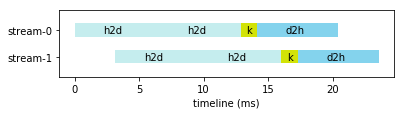

In [33]:
cuda_timeline.plot_cke_list(df_cke_list, savefig=True)

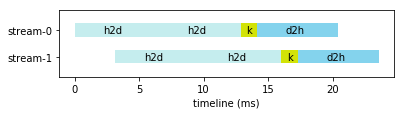

In [34]:
cuda_timeline.plot_cke_list(df_cke_list[0:2])

In [35]:
tot_runtime = read_trace.getTotalRuntime(df_cke_list[0:2])
print tot_runtime

20.432566
